# 5. Compositional Tracking

This notebook demonstrates the compositional tracking capabilities in TriPoD, which allows you to track multiple chemical species through gas and dust phases including sublimation and condensation processes.

TriPoD extends the basic dust evolution framework to include:
- Multiple chemical components with distinct properties
- Gas and dust phases for each component
- Sublimation and condensation processes

## Setting Up a Simulation with Components

Let's start by importing the necessary modules and creating a simulation object.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tripod
import dustpy.constants as c

# Create simulation object
sim = tripod.Simulation()

# Basic setup
sim.ini.grid.Nr = 50
sim.ini.grid.rmin = 1.0 * c.au
sim.ini.grid.rmax = 100.0 * c.au

# Initialize the simulation
sim.initialize()

## Default Components

By default, TriPoD creates two gas components: H₂ (molecular hydrogen) and He (helium). Let's examine the components structure:

In [5]:
# List all components
print("Available components:")
for name in sim.components.__dict__.keys():
    if not name.startswith('_'):
        comp = sim.components.__dict__[name]
        print(f"  {name}: {comp.description}")

Available components:
  H2: Molecular hydrogenH2 (dust_active=False, gas_active=True, gas_tracer=False)
  He: Atomic heliumHe (dust_active=False, gas_active=True, gas_tracer=False)


Each component can have one of 4 distinct beaviours:

- dust_active=False, gas_active=True, gas_tracer=False: Active gas component (e.g. H2)

    This component type contributes to the gas dynamics by contibuting to the total gas density and mean molecular weight as described in [Pavlyuchenkov and Dullemond (2027)](http://www.aanda.org/10.1051/0004-6361:20077317)

- dust_active=False, gas_active=False, gas_tracer=True:
    This is a apssivetracer that gets advected with the gas and can represent any quantity thats advected with the gas e.g. measuring the gas flux threw a gab by  introducing a tracer with 0 inside and 1 outisde of the gap 

- dust_active=True, gas_active=False, gas_tracer=False:
    same as above just a passive tracer for the dust that gets exchanged between the two mass bins on the collisonal timescale as described in 0.

- dust_active=True, gas_active=True, gas_tracer=False:
    a chemical component that evaporates and condensates according to its chemcal properties 
    

## Adding Custom Components

Let's show how to add the different types of components to the simulation

In [ ]:
#Gas component
mu_CO = 28.01 * c.m_p  # 28.01 amu in grams
Sigma_gas_CO = sim.gas.Sigma * 1e-4  # Initial
sim.addcomponent_c("CO",Sigma_gas_CO,1,dust_value=sim.dust.SigmaFloor.copy() 
                   ,dust_active=False, gas_active=True, gas_tracer=False)

lets look at how the newly updatedcomponent class looks:

In [8]:
sim.components.toc

Group (components)
    - CO: Group (CO (dust_active=False, gas_active=True, gas_tracer=False))
        - boundary: Group (Boundary conditions for component)
            - inner: Value
            - outer: Value
        - dust: Group (Dust related fields)
            - S: Field (tracer source term [???/s])
            - S_Sigma: Field (Source term for dust surface density [g/cm²])
            - value: Field (tracer value [???])
        - gas: Group (Gas related fields)
            - Fi: Field (Gas flux [g/cm²/s])
            - pars: Group (Gas parameters)
                - mu: Field (Mean molecular weight [g])
                - nu: Field (trial frequency [1/s])
                - Tsub: Field (evaporation temperatue [K])
            - S: Group (Gas source terms)
                - ext: Field (External source term [g/cm²/s])
                - hyd: Field (Hydrodynamical source term [g/cm²/s])
                - tot: Field (Total source term [g/cm²/s])
            - Sigma: Field (Gas surface d

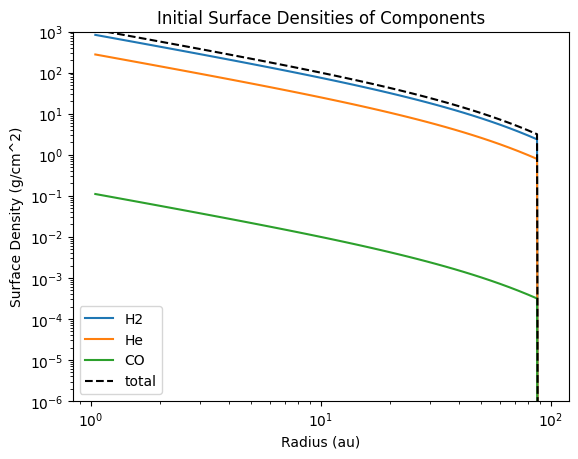

In [17]:
plt.figure()
for name, comp in sim.components.__dict__.items():
    if not name.startswith('_'):
        plt.plot(sim.grid.r / c.au, comp.gas.Sigma, label=name)
plt.plot(sim.grid.r / c.au, sim.gas.Sigma, label='total', linestyle='--', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (au)')
plt.ylabel('Surface Density (g/cm^2)')
plt.legend()
plt.title('Initial Surface Densities of Components')
plt.ylim(1e-6, 1e3)
plt.show()

we can also see that the extra integration step was added for the CO component

In [10]:
sim.integrator.instructions

[Instruction (Dust (state vector): implicit 1st-order direct solver),
 Instruction (H2: implicit 1st-order direct solver for tracers),
 Instruction (He: implicit 1st-order direct solver for tracers),
 Instruction (CO: implicit 1st-order direct solver for tracers)]

Now lets add a gas tracer

In [18]:
# Define initial value for the tracers
tr = np.zeros_like(sim.grid.r)*1e-5
tr[sim.grid.r<10*c.au] = 1.0
trd = tr[:,None]*np.ones_like(sim.dust.Sigma)

sim.addcomponent_c("tr",tr,1,dust_active=False, gas_active=False, gas_tracer=True)

Note that tracers have the property .value rather than .Sigma as it is conceptually not the same thing and does not contribute to the gas dynamics

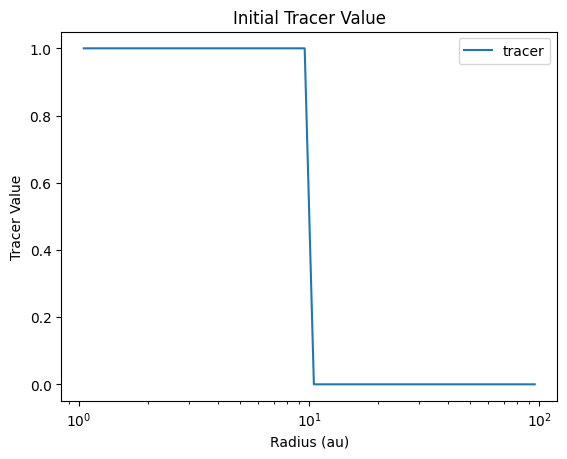

In [21]:
plt.figure()
plt.plot(sim.grid.r/c.au, sim.components.tr.gas.value, label='tracer')
plt.xscale('log')
plt.xlabel('Radius (au)')
plt.ylabel('Tracer Value')
plt.title('Initial Tracer Value')
plt.legend()
plt.show()

For conveience the sigma property is also defined for tracers (and value for active species) but will return 0 if called and is not able to be overwritten

In [22]:
sim.components.tr.gas.Sigma

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

In [23]:
sim.components.tr.gas.Sigma = np.ones_like(sim.grid.r)

RuntimeError: Do not set Sigma for inactive gas species.

now lets add a dust tracer

In [ ]:
sim.addcomponent_c("trdust",None,0.32,dust_value=trd,dust_active=True, gas_active=False, gas_tracer=False)

the Dust tracer has the same dimension as the dust surface desity an follows the total dust fluid by default (i.e. it ges transported between the mass bins on the same timescale as the dust surface density)

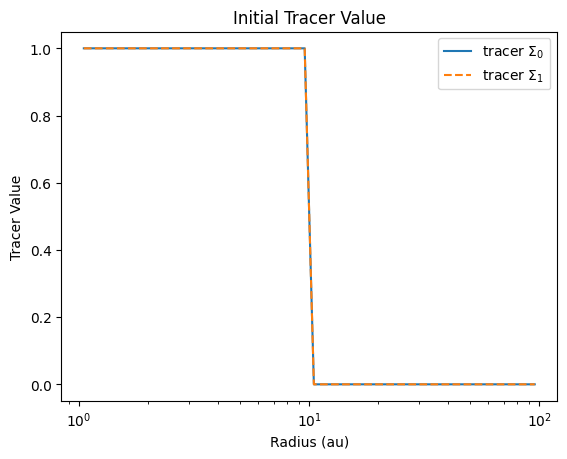

In [30]:
from matplotlib.lines import lineStyles


plt.figure()
plt.plot(sim.grid.r/c.au, sim.components.trdust.dust.value[:,0], label=r'tracer $\Sigma_0$')
plt.plot(sim.grid.r/c.au, sim.components.trdust.dust.value[:,1], label=r'tracer $\Sigma_1$',linestyle="--")
plt.xscale('log')
plt.xlabel('Radius (au)')
plt.ylabel('Tracer Value')
plt.title('Initial Tracer Value')
plt.legend()
plt.show()

Now let's add a water ice component that can exist in both gas and dust phases and undergoes sublimation/condensation:

In [ ]:

sim.addcomponent_c("CO",sim.gas.SigmaFloor,1,dust_value=sim.gas.Sigma[:,None]*1e-4/2./sim.dust.Sigma ,dust_active=True, gas_active=True, gas_tracer=False)
sim.components.COinv.gas.pars.mu = 28 * c.m_p
sim.components.COinv.gas.pars.nu = 7.0e11
sim.components.COinv.gas.pars.Tsub = 1180

In [ ]:





sim.addcomponent_c("tr",tr,0.32,dust_active=False, gas_active=False, gas_tracer=True)
sim.addcomponent_c("trd",tr,0.32,dust_value=trd,dust_active=True, gas_active=False, gas_tracer=False)

sim.addcomponent_c("CO",sim.gas.Sigma*1e-4,1,dust_value=sim.dust.SigmaFloor.copy() ,dust_active=True, gas_active=True, gas_tracer=False)
sim.addcomponent_c("COinv",sim.gas.SigmaFloor,1,dust_value=sim.gas.Sigma[:,None]*1e-4/2./sim.dust.Sigma ,dust_active=True, gas_active=True, gas_tracer=False)
sim.components.CO.gas.pars.mu = 28 * c.m_p
sim.components.CO.gas.pars.nu = 7.0e11
sim.components.CO.gas.pars.Tsub = 1180
sim.components.COinv.gas.pars.mu = 28 * c.m_p
sim.components.COinv.gas.pars.nu = 7.0e11
sim.components.COinv.gas.pars.Tsub = 1180

# Set component-specific parameters
comp_H2O = sim.components.H2O



# Sublimation temperature (water ice line ~ 150 K)
comp_H2O.Tsub = 150.0  # K

# Attempt frequency for sublimation (typical value)
comp_H2O.nu = 1e13  # Hz

# Initialize dust surface density (more ice in outer regions)
ice_abundance = np.where(sim.gas.T < comp_H2O.Tsub, 0.01, 1e-10)  # 1% abundance where T < 150K
comp_H2O.dust.Sigma = ice_abundance * sim.gas.Sigma[:, None]

print(f"Added water component with:")
print(f"  Sublimation temperature: {comp_H2O.Tsub} K")
print(f"  Attempt frequency: {comp_H2O.nu:.1e} Hz")
print(f"  Molecular weight: {comp_H2O.gas.mu / c.m_p:.2f} amu")

## Understanding Sublimation and Condensation

TriPoD includes sophisticated models for sublimation and condensation that depend on:
- Grain surface area
- Temperature
- Binding site density
- Sticking probability

Let's examine the sublimation and condensation rates:

In [ ]:
# Import the sublimation and condensation functions
from tripod.std.compo import L_sublimation, L_condensation, A_grains

# Calculate grain surface area
A_total = A_grains(sim)

# Calculate sublimation rate for water
L_sub = L_sublimation(sim, name="H2O")

# Calculate condensation rate for water (with sticking probability = 1)
L_con = L_condensation(sim, name="H2O", Pstick=1.0)

print(f"Surface area shape: {A_total.shape}")
print(f"Sublimation rate shape: {L_sub.shape}")
print(f"Condensation rate shape: {L_con.shape}")

## Visualizing Component Distributions

Let's plot the initial distribution of our components and see where sublimation/condensation is most important:

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

r_au = sim.grid.r / c.au

# Plot 1: Temperature profile
axes[0,0].loglog(r_au, sim.gas.T)
axes[0,0].axhline(comp_H2O.Tsub, color='red', linestyle='--', label=f'H2O ice line ({comp_H2O.Tsub} K)')
axes[0,0].set_xlabel('Radius [au]')
axes[0,0].set_ylabel('Temperature [K]')
axes[0,0].set_title('Temperature Profile')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Gas surface densities
axes[0,1].loglog(r_au, sim.components.H2.gas.Sigma, label='H₂ gas', color='blue')
axes[0,1].loglog(r_au, sim.components.He.gas.Sigma, label='He gas', color='orange')
axes[0,1].loglog(r_au, sim.components.H2O.gas.Sigma, label='H₂O gas', color='cyan')
axes[0,1].set_xlabel('Radius [au]')
axes[0,1].set_ylabel('Gas Surface Density [g/cm²]')
axes[0,1].set_title('Gas Phase Components')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Water ice distribution
axes[1,0].loglog(r_au, comp_H2O.dust.Sigma[:, 0], label='Small ice grains', color='lightblue')
axes[1,0].loglog(r_au, comp_H2O.dust.Sigma[:, 1], label='Large ice grains', color='darkblue')
axes[1,0].set_xlabel('Radius [au]')
axes[1,0].set_ylabel('Ice Surface Density [g/cm²]')
axes[1,0].set_title('Water Ice Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Sublimation vs condensation rates
# Only plot where we have significant ice
mask = comp_H2O.dust.Sigma[:, 0] > 1e-15
axes[1,1].loglog(r_au[mask], L_sub[mask, 0], label='Sublimation rate', color='red')
axes[1,1].loglog(r_au[mask], L_con[mask, 0], label='Condensation rate', color='blue')
axes[1,1].set_xlabel('Radius [au]')
axes[1,1].set_ylabel('Rate [s⁻¹]')
axes[1,1].set_title('Sublimation vs Condensation Rates')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Running Evolution with Component Tracking

Now let's run a short evolution to see how the components evolve over time. Note that the compositional tracking integrator handles the coupling between gas and dust phases:

In [ ]:
# Store initial conditions for comparison
initial_gas_H2O = sim.components.H2O.gas.Sigma.copy()
initial_ice_H2O = sim.components.H2O.dust.Sigma.copy()

# Set up for a short evolution
sim.t.snapshots = np.array([0, 1e3, 1e4, 1e5]) * c.year  # 0, 1000, 10k, 100k years

print("Running simulation with component tracking...")
print(f"Initial total gas: {sim.gas.Sigma.sum():.2e} g/cm²")
print(f"Initial H2O gas: {sim.components.H2O.gas.Sigma.sum():.2e} g/cm²")
print(f"Initial H2O ice: {sim.components.H2O.dust.Sigma.sum():.2e} g/cm²")

# Note: For demonstration, we'll just update once to show the structure
# In practice, you would call sim.run() for full evolution
sim.update()

print("\nSimulation structure ready for evolution with compositional tracking.")

## Component Integration and Jacobian

The compositional tracking uses sophisticated implicit integration methods that account for the coupling between gas and dust phases. Let's examine the Jacobian structure:

In [ ]:
# Import the compositional Jacobian function
from tripod.std.compo import jacobian_compo

# Calculate the Jacobian for the H2O component
J_H2O = jacobian_compo(sim, sim.t, name="H2O")

print(f"Jacobian shape: {J_H2O.shape}")
print(f"Number of non-zero elements: {J_H2O.nnz}")
print(f"Sparsity: {J_H2O.nnz / (J_H2O.shape[0] * J_H2O.shape[1]):.2%}")

# The Jacobian couples:
# - Gas phase evolution (first Nr entries)
# - Dust phase evolution (remaining entries)
# - Sublimation/condensation coupling between phases

Nr = sim.grid.Nr
print(f"\nJacobian structure:")
print(f"  Gas phase block: rows/cols 0-{Nr-1}")
print(f"  Dust phase block: rows/cols {Nr}-{J_H2O.shape[0]-1}")
print(f"  Off-diagonal blocks represent gas-dust coupling")

## Advanced Component Configuration

Let's add another component to demonstrate more complex scenarios:

In [ ]:
# Add CO component (carbon monoxide)
Sigma_gas_CO = 1e-6 * sim.gas.Sigma  # Start with small amount in gas
mu_CO = 28.01 * c.m_p  # 28.01 amu

sim.addcomponent(
    "CO", 
    Sigma_gas_CO, 
    mu_CO, 
    tracer=False,
    includegas=True, 
    includedust=True, 
    description="Carbon monoxide (gas and ice)"
)

# CO ice line is typically around 20 K
comp_CO = sim.components.CO
comp_CO.Tsub = 20.0  # K
comp_CO.nu = 5e12  # Hz (different from water)

# Initialize CO ice (only in very cold regions)
co_ice_abundance = np.where(sim.gas.T < comp_CO.Tsub, 0.005, 1e-12)  # 0.5% where cold
comp_CO.dust.Sigma = co_ice_abundance * sim.gas.Sigma[:, None]

print(f"Added CO component:")
print(f"  Sublimation temperature: {comp_CO.Tsub} K")
print(f"  Much colder ice line than water!")

# Summary of all components
print("\nComponent summary:")
for name in sim.components.__dict__.keys():
    if not name.startswith('_'):
        comp = sim.components.__dict__[name]
        print(f"  {name}: gas={comp.includegas}, dust={comp.includedust}")
        if hasattr(comp, 'Tsub'):
            print(f"    Sublimation T: {comp.Tsub} K")

## Comparing Ice Lines

Let's visualize the different ice lines for our components:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Temperature with ice lines
ax1.loglog(r_au, sim.gas.T, 'k-', linewidth=2, label='Temperature')
ax1.axhline(comp_H2O.Tsub, color='blue', linestyle='--', linewidth=2, label=f'H₂O ice line ({comp_H2O.Tsub} K)')
ax1.axhline(comp_CO.Tsub, color='red', linestyle='--', linewidth=2, label=f'CO ice line ({comp_CO.Tsub} K)')
ax1.set_xlabel('Radius [au]')
ax1.set_ylabel('Temperature [K]')
ax1.set_title('Temperature Profile and Ice Lines')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(10, 1000)

# Plot 2: Ice distributions
ax2.loglog(r_au, comp_H2O.dust.Sigma[:, 0], 'b-', linewidth=2, label='H₂O ice')
ax2.loglog(r_au, comp_CO.dust.Sigma[:, 0], 'r-', linewidth=2, label='CO ice')
ax2.set_xlabel('Radius [au]')
ax2.set_ylabel('Ice Surface Density [g/cm²]')
ax2.set_title('Ice Distributions')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find approximate ice line locations
h2o_iceline_idx = np.argmin(np.abs(sim.gas.T - comp_H2O.Tsub))
co_iceline_idx = np.argmin(np.abs(sim.gas.T - comp_CO.Tsub))

print(f"\nApproximate ice line locations:")
print(f"  H₂O ice line: {r_au[h2o_iceline_idx]:.1f} au")
print(f"  CO ice line: {r_au[co_iceline_idx]:.1f} au")

## Key Parameters for Compositional Tracking

Here's a summary of the important parameters you can control for each component:

In [ ]:
print("Key parameters for compositional tracking:")
print("\n1. Component properties:")
print("   - molecular weight (mu): affects condensation rate")
print("   - includegas/includedust: which phases to track")
print("   - tracer: whether component affects dynamics")

print("\n2. Sublimation parameters:")
print("   - Tsub: sublimation temperature [K]")
print("   - nu: attempt frequency [Hz]")
print("   - N_bind: binding site density [cm⁻²] (default: 1e15)")

print("\n3. Condensation parameters:")
print("   - Pstick: sticking probability (0-1, default: 1)")
print("   - Surface area of grains (calculated from size distribution)")

print("\n4. Physical processes included:")
print("   - Temperature-dependent sublimation rates")
print("   - Surface area dependent condensation")
print("   - Multi-layer desorption for thick ice mantles")
print("   - Implicit coupling between gas and dust phases")

# Example of how to modify parameters
print("\nExample parameter modifications:")
print("# Modify sticking probability in condensation calculation:")
print("L_con_low_stick = L_condensation(sim, name='H2O', Pstick=0.1)")
print("\n# Modify binding site density in sublimation:")
print("L_sub_high_bind = L_sublimation(sim, name='H2O', N_bind=1e16)")

## Summary

This notebook has demonstrated the key compositional tracking capabilities in TriPoD:

1. **Multi-component setup**: How to add components with gas and/or dust phases
2. **Component parameters**: Setting molecular weights, sublimation temperatures, and other properties
3. **Phase transitions**: Understanding sublimation and condensation processes
4. **Ice lines**: How different components freeze out at different temperatures
5. **Integration**: The implicit solver that handles gas-dust coupling

The compositional tracking framework enables realistic modeling of:
- Volatile transport in protoplanetary disks
- Planet formation in different chemical environments
- Evolution of disk composition over time
- Ice line migration and chemical gradients

For production simulations, you would typically:
1. Set up your desired components with appropriate parameters
2. Configure the integrator for your timescales
3. Run the full evolution with `sim.run()`
4. Analyze the evolving composition throughout the disk